# NeuroFetal AI — V4.0 TimeGAN Synthetic CTG Generation

**Branch:** `feat/v4.0-timegan`

**Objective:** Train a 1D Convolutional GAN on the minority-class (Pathological) FHR+UC signals to generate realistic synthetic fetal distress traces, replacing SMOTE for class balancing.

### Pipeline
| # | Phase | Description |
|---|-------|-------------|
| 1 | Setup | Clone repo, install deps, authenticate |
| 2 | Data Prep | Load `.npy`, isolate pathological traces, stack FHR+UC |
| 3 | Architecture | Build 1D Conv Generator + Discriminator |
| 4 | Training | Custom `tf.GradientTape` loop with WGAN-GP |
| 5 | Visualization | Compare real vs synthetic traces |
| 6 | Export | Save synthetic `.npy` files |
| 7 | Push | Commit results back to GitHub |

---
## 1. Setup Environment

In [1]:
from google.colab import userdata
import os

GITHUB_REPO = "Krishna200608/NeuroFetal-AI"

try:
    GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
    print("✓ GitHub Token loaded from Secrets.")
except Exception as e:
    print("⚠️ Falling back to manual input.")
    from getpass import getpass
    GITHUB_TOKEN = getpass("Enter GitHub PAT: ")

os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
os.environ['GITHUB_REPO'] = GITHUB_REPO

✓ GitHub Token loaded from Secrets.


In [2]:
import shutil, os

try:
    os.chdir("/content")
except:
    pass

if os.path.exists("/content/NeuroFetal-AI"):
    shutil.rmtree("/content/NeuroFetal-AI")

print("Cloning repository...")
!git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_REPO}.git
os.chdir("/content/NeuroFetal-AI")

!git config --global user.email "krishnasikheriya001@gmail.com"
!git config --global user.name "Krishna200608"

!git fetch origin
!git checkout feat/v4.0-timegan
print("✓ Cloned and checked out feat/v4.0-timegan!")

Cloning repository...
Cloning into 'NeuroFetal-AI'...
remote: Enumerating objects: 2311, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 2311 (delta 210), reused 184 (delta 132), pack-reused 2026 (from 3)
Receiving objects: 100% (2311/2311), 766.56 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (1341/1341), done.
Updating files: 100% (1220/1220), done.
Branch 'feat/v4.0-timegan' set up to track remote branch 'feat/v4.0-timegan' from 'origin'.
Switched to a new branch 'feat/v4.0-timegan'
✓ Cloned and checked out feat/v4.0-timegan!


In [3]:
print("Installing dependencies...")
!pip install -q wfdb scipy imbalanced-learn scikit-learn matplotlib seaborn pandas numpy tensorflow
print("✓ Dependencies installed.")

Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 123.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.1 which is incompatible.
dask-cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.1 wh

---
## 2. Data Ingestion & Pathological Isolation

Run the existing data pipeline, then isolate **only** the minority class (`y == 1`, Compromised pH < 7.15). We stack FHR + UC into a `(N, 1200, 2)` tensor to preserve their physiological cross-correlation (late decelerations following contractions).

In [4]:
# Run standard data ingestion first
!python Code/scripts/data_ingestion.py

Found 552 records.
pH threshold: 7.15
Max signal loss: 50%
Processed 100 records...
Processed 200 records...
Processed 300 records...
Processed 400 records...
Processed 500 records...

Processing complete.
  Patients: 552
  Total windows: 2546
  Skipped (quality): 214
  Shapes: X_fhr=(2546, 1200), X_uc=(2546, 1200), X_tabular=(2546, 18), y=(2546,)
  Tabular features (18): ['Age', 'Parity', 'Gestation', 'Gravidity', 'Weight', 'fhr_baseline', 'fhr_stv', 'fhr_ltv', 'fhr_accel_count', 'fhr_decel_count', 'fhr_decel_area', 'fhr_range', 'fhr_iqr', 'fhr_entropy', 'uc_freq', 'uc_intensity_mean', 'fhr_uc_lag', 'signal_loss_pct']
  Class balance: 470.0 compromised / 2546 total (18.5%)


Full dataset — FHR: (2546, 1200), UC: (2546, 1200), Tab: (2546, 18), y: (2546,)
Class balance: 470 pathological / 2546 total (18.46%)
  Expanded FHR to 3D: (2546, 1200, 1)
  Expanded UC  to 3D: (2546, 1200, 1)

Pathological samples isolated: 470
Stacked signal shape: (470, 1200, 2)  (expected: N, 1200, 2)


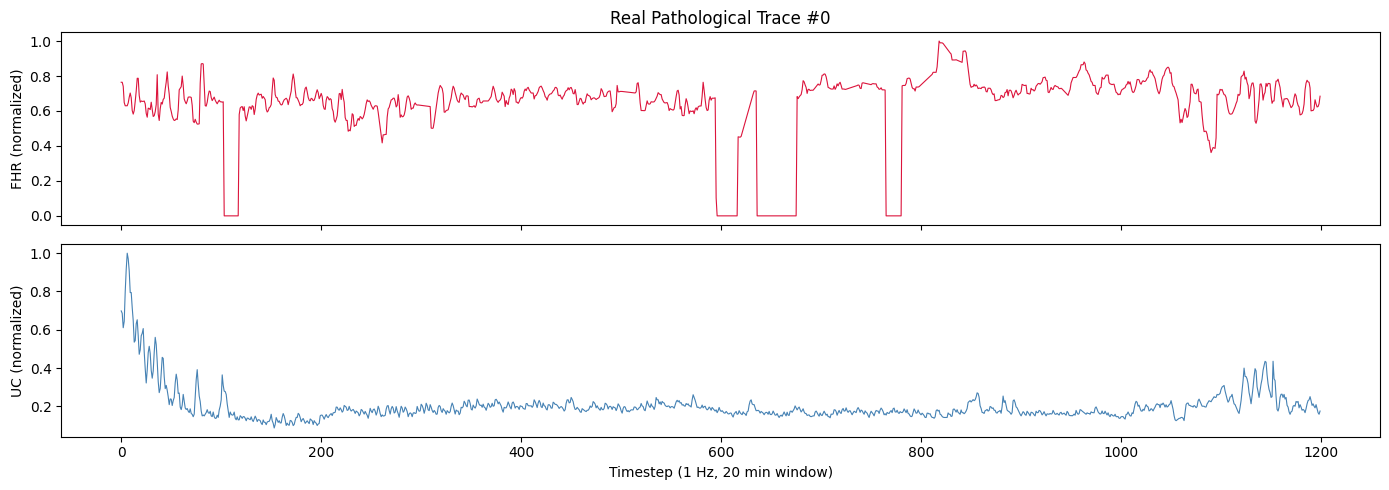

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ── Load preprocessed data ──
X_fhr = np.load("Datasets/processed/X_fhr.npy")
X_uc  = np.load("Datasets/processed/X_uc.npy")
X_tab = np.load("Datasets/processed/X_tabular.npy")
y     = np.load("Datasets/processed/y.npy")

print(f"Full dataset — FHR: {X_fhr.shape}, UC: {X_uc.shape}, Tab: {X_tab.shape}, y: {y.shape}")
print(f"Class balance: {y.sum():.0f} pathological / {len(y)} total ({y.mean()*100:.2f}%)")

# ── CRITICAL: Ensure 3D shape: (N, 1200) → (N, 1200, 1) ──
# data_ingestion.py saves as 2D; we need 3D for channel stacking
if X_fhr.ndim == 2:
    X_fhr = np.expand_dims(X_fhr, axis=-1)
    print(f"  Expanded FHR to 3D: {X_fhr.shape}")
if X_uc.ndim == 2:
    X_uc = np.expand_dims(X_uc, axis=-1)
    print(f"  Expanded UC  to 3D: {X_uc.shape}")

# ── Isolate minority class ──
patho_idx = np.where(y == 1)[0]
X_fhr_patho = X_fhr[patho_idx]  # (N_patho, 1200, 1)
X_uc_patho  = X_uc[patho_idx]   # (N_patho, 1200, 1)

# ── Stack FHR + UC into 2-channel signal ──
# Shape: (N_patho, 1200, 2) — Channel 0 = FHR, Channel 1 = UC
X_patho_stacked = np.concatenate([X_fhr_patho, X_uc_patho], axis=-1)

print(f"\nPathological samples isolated: {X_patho_stacked.shape[0]}")
print(f"Stacked signal shape: {X_patho_stacked.shape}  (expected: N, 1200, 2)")
assert X_patho_stacked.shape[1:] == (1200, 2), f"Shape mismatch! Got {X_patho_stacked.shape}"

# ── Quick visualization of a real pathological trace ──
fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
sample_idx = 0
axes[0].plot(X_patho_stacked[sample_idx, :, 0], color='crimson', linewidth=0.8)
axes[0].set_ylabel('FHR (normalized)')
axes[0].set_title(f'Real Pathological Trace #{sample_idx}')
axes[1].plot(X_patho_stacked[sample_idx, :, 1], color='steelblue', linewidth=0.8)
axes[1].set_ylabel('UC (normalized)')
axes[1].set_xlabel('Timestep (1 Hz, 20 min window)')
plt.tight_layout()
plt.show()

---
## 3. TimeGAN Architecture (1D Convolutional WGAN-GP)

We use a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** architecture built entirely with 1D Convolutions.

### Design Rationale
- **Why not RNNs?** At sequence length 1200, LSTMs/GRUs suffer from vanishing gradients and are extremely slow to train.
- **Why WGAN-GP?** Standard GAN training with BCE loss is notoriously unstable. WGAN-GP uses the Wasserstein distance + gradient penalty for much more stable convergence on small datasets.
- **Why 2-channel?** By generating FHR and UC simultaneously, we preserve their physiological cross-correlation (e.g., late decelerations follow contractions).

### Architecture Summary
| Component | Input | Output | Key Layers |
|-----------|-------|--------|------------|
| **Generator** | `(batch, 128)` noise | `(batch, 1200, 2)` | Dense → Reshape → 4x Conv1DTranspose (upsampling) → tanh |
| **Critic** | `(batch, 1200, 2)` signal | `(batch, 1)` score | 4x Conv1D (downsampling) → Dense → linear |

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ═══════════════════════════════════════════════════════════════════
# Hyperparameters
# ═══════════════════════════════════════════════════════════════════
NOISE_DIM      = 128       # Latent space dimension
SEQ_LEN        = 1200      # 20 min at 1 Hz
N_CHANNELS     = 2         # FHR + UC
BATCH_SIZE     = 16        # Small for Colab T4 VRAM
GP_WEIGHT      = 10.0      # Gradient penalty coefficient
N_CRITIC       = 5         # Critic updates per generator update
EPOCHS         = 500       # Total training epochs
LR_G           = 1e-4      # Generator learning rate
LR_D           = 1e-4      # Critic learning rate

# ═══════════════════════════════════════════════════════════════════
# GENERATOR: Noise → (1200, 2) synthetic CTG signal
# Strategy: Dense → Reshape to (75, 256) → 4 Conv1DTranspose blocks
# to progressively upsample: 75 → 150 → 300 → 600 → 1200
# ═══════════════════════════════════════════════════════════════════
def build_generator():
    model = keras.Sequential(name="Generator")

    # Project noise to a small temporal tensor
    model.add(layers.Dense(75 * 256, input_dim=NOISE_DIM))
    model.add(layers.Reshape((75, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Block 1: 75 → 150
    model.add(layers.Conv1DTranspose(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Block 2: 150 → 300
    model.add(layers.Conv1DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Block 3: 300 → 600
    model.add(layers.Conv1DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Block 4: 600 → 1200
    model.add(layers.Conv1DTranspose(32, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Output: (1200, 2) — tanh for normalized signals
    model.add(layers.Conv1D(N_CHANNELS, kernel_size=7, padding='same', activation='tanh'))

    return model

# ═══════════════════════════════════════════════════════════════════
# CRITIC (Discriminator): (1200, 2) signal → scalar Wasserstein score
# Strategy: 4 Conv1D blocks to downsample: 1200 → 600 → 300 → 150 → 75
# ═══════════════════════════════════════════════════════════════════
def build_critic():
    model = keras.Sequential(name="Critic")

    # Block 1: 1200 → 600
    model.add(layers.Conv1D(32, kernel_size=5, strides=2, padding='same', input_shape=(SEQ_LEN, N_CHANNELS)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    # Block 2: 600 → 300
    model.add(layers.Conv1D(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    # Block 3: 300 → 150
    model.add(layers.Conv1D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    # Block 4: 150 → 75
    model.add(layers.Conv1D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    # Flatten → score (no sigmoid for WGAN)
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Linear output for Wasserstein distance

    return model

# ── Build and inspect ──
generator = build_generator()
critic    = build_critic()

print("="*60)
generator.summary()
print("\n" + "="*60)
critic.summary()

# Quick sanity check
test_noise = tf.random.normal((1, NOISE_DIM))
test_output = generator(test_noise)
print(f"\n✓ Generator output shape: {test_output.shape}  (expected: (1, 1200, 2))")
test_score = critic(test_output)
print(f"✓ Critic output shape: {test_score.shape}  (expected: (1, 1))")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 19200)          │     2,476,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 150, 256)       │       327,936 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 300, 128)       │       163,968 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 600, 64)        │        41,024 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 600, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 600, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 1200, 32)       │        10,272 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1200, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1200, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1200, 2)        │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,023,394 (11.53 MB)

 Trainable params: 3,021,922 (11.53 MB)

 Non-trainable params: 1,472 (5.75 KB)

Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 600, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 600, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 600, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 300, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 150, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 75, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        19,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,041 (918.13 KB)

 Trainable params: 235,041 (918.13 KB)

 Non-trainable params: 0 (0.00 B)


✓ Generator output shape: (1, 1200, 2)  (expected: (1, 1200, 2))
✓ Critic output shape: (1, 1)  (expected: (1, 1))


---
## 4. WGAN-GP Training Loop

Custom training with:
- **Wasserstein loss** (Critic maximizes `E[D(real)] - E[D(fake)]`)
- **Gradient Penalty** for Lipschitz constraint enforcement
- **5:1 Critic-to-Generator update ratio** for stable convergence
- **Visualization** every 50 epochs to track morphological quality

Training data: (470, 1200, 2) normalized to [-1, 1]
Batches per epoch: 29

Starting WGAN-GP Training — 500 epochs
Generator LR: 0.0001, Critic LR: 0.0001
Critic updates per G update: 5
Batch size: 16

Epoch    1/500 | D Loss:   6.7463 | G Loss:   0.2374 | W Dist:  -0.3418 | Time: 10s
Epoch   10/500 | D Loss: -19.5564 | G Loss:  12.2986 | W Dist: -25.6956 | Time: 14s
Epoch   20/500 | D Loss: -17.0554 | G Loss:  16.8748 | W Dist: -21.7937 | Time: 18s
Epoch   30/500 | D Loss: -16.5295 | G Loss:  21.0899 | W Dist: -21.0646 | Time: 23s
Epoch   40/500 | D Loss: -17.1581 | G Loss:  22.0579 | W Dist: -21.6094 | Time: 27s
Epoch   50/500 | D Loss: -17.0160 | G Loss:  16.9638 | W Dist: -21.4082 | Time: 31s


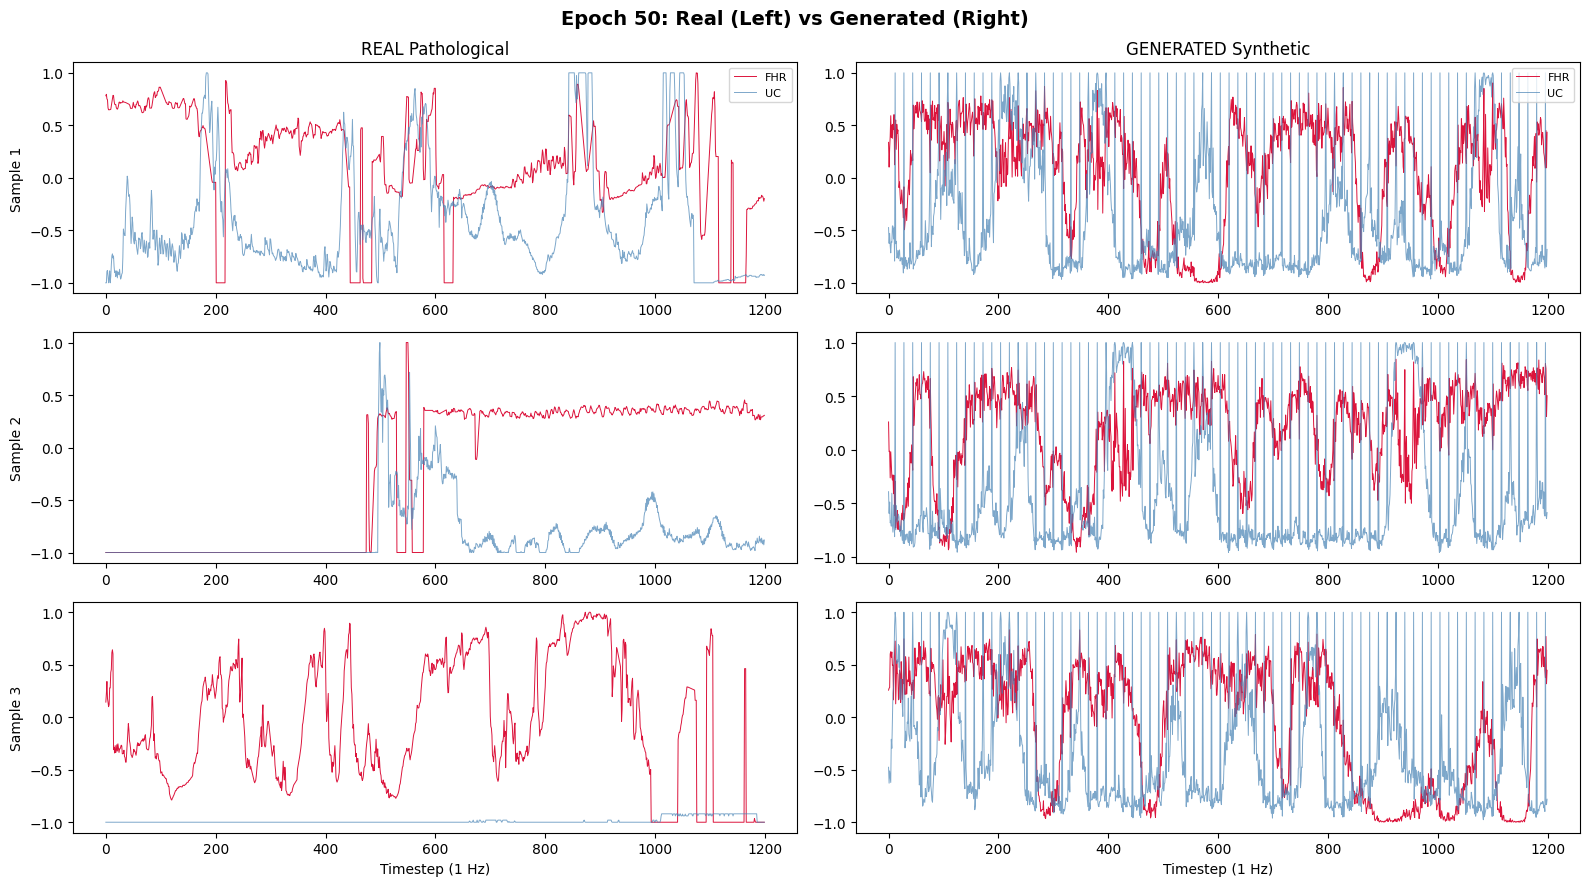

Epoch   60/500 | D Loss: -17.3138 | G Loss:  14.9924 | W Dist: -21.7781 | Time: 37s
Epoch   70/500 | D Loss: -17.2439 | G Loss:  12.6209 | W Dist: -21.6996 | Time: 41s
Epoch   80/500 | D Loss: -17.3956 | G Loss:  15.5540 | W Dist: -21.7940 | Time: 45s
Epoch   90/500 | D Loss: -17.3063 | G Loss:   8.2885 | W Dist: -21.7297 | Time: 49s
Epoch  100/500 | D Loss: -17.6011 | G Loss:  13.8743 | W Dist: -22.0277 | Time: 53s


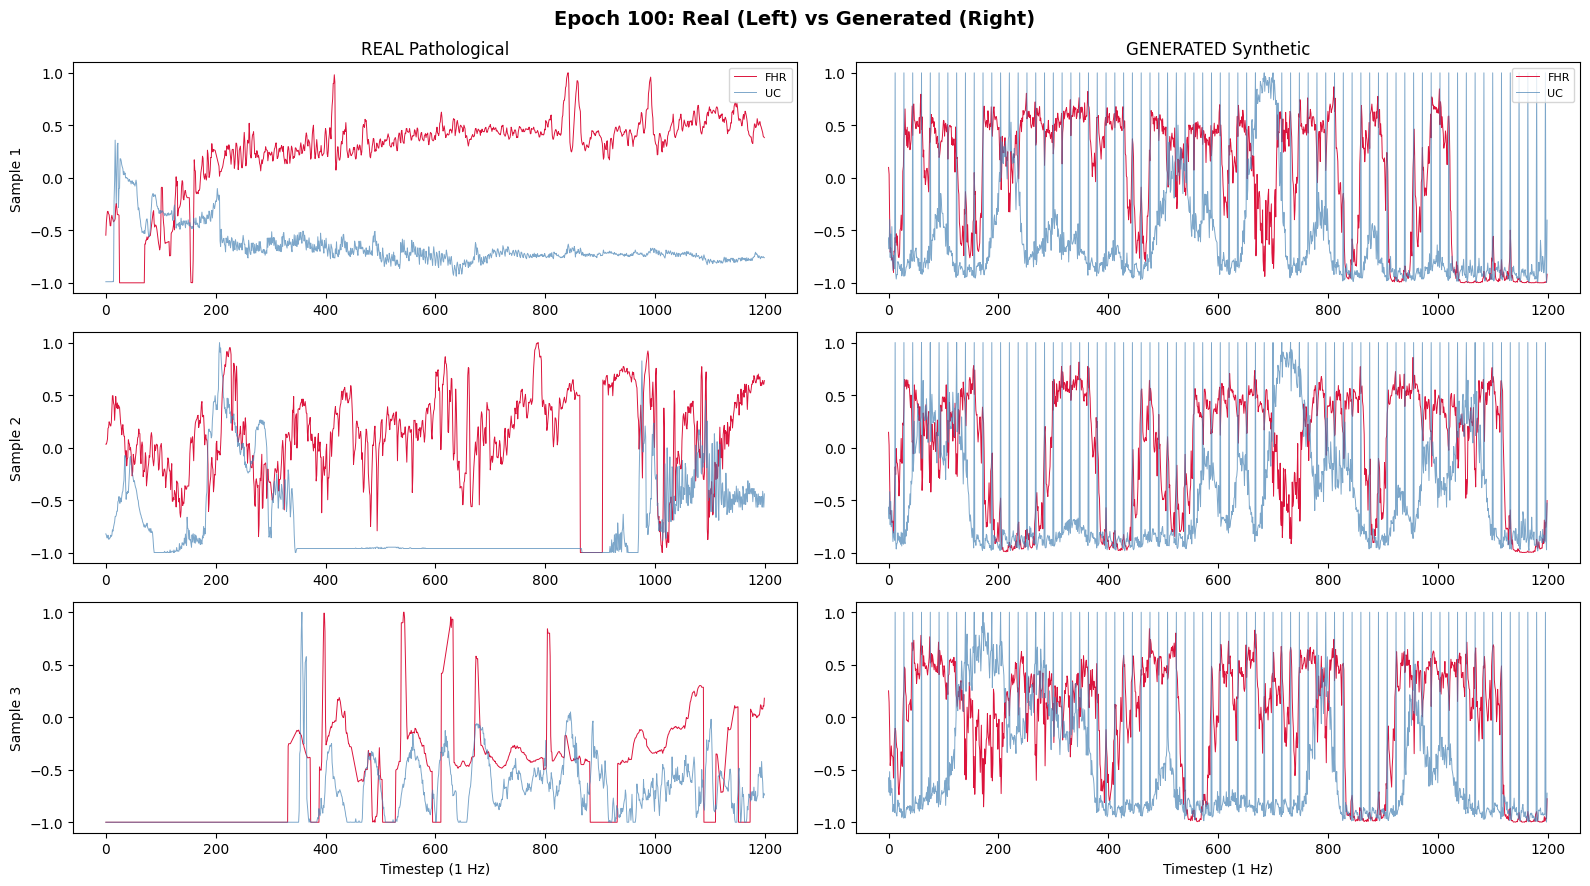

Epoch  110/500 | D Loss: -17.3634 | G Loss:   9.7556 | W Dist: -21.7855 | Time: 60s
Epoch  120/500 | D Loss: -17.6472 | G Loss:   9.1289 | W Dist: -22.0936 | Time: 64s
Epoch  130/500 | D Loss: -17.5608 | G Loss:   7.0075 | W Dist: -21.9695 | Time: 68s
Epoch  140/500 | D Loss: -17.2522 | G Loss:  11.4864 | W Dist: -21.6678 | Time: 72s
Epoch  150/500 | D Loss: -17.4977 | G Loss:  13.0859 | W Dist: -21.9186 | Time: 76s


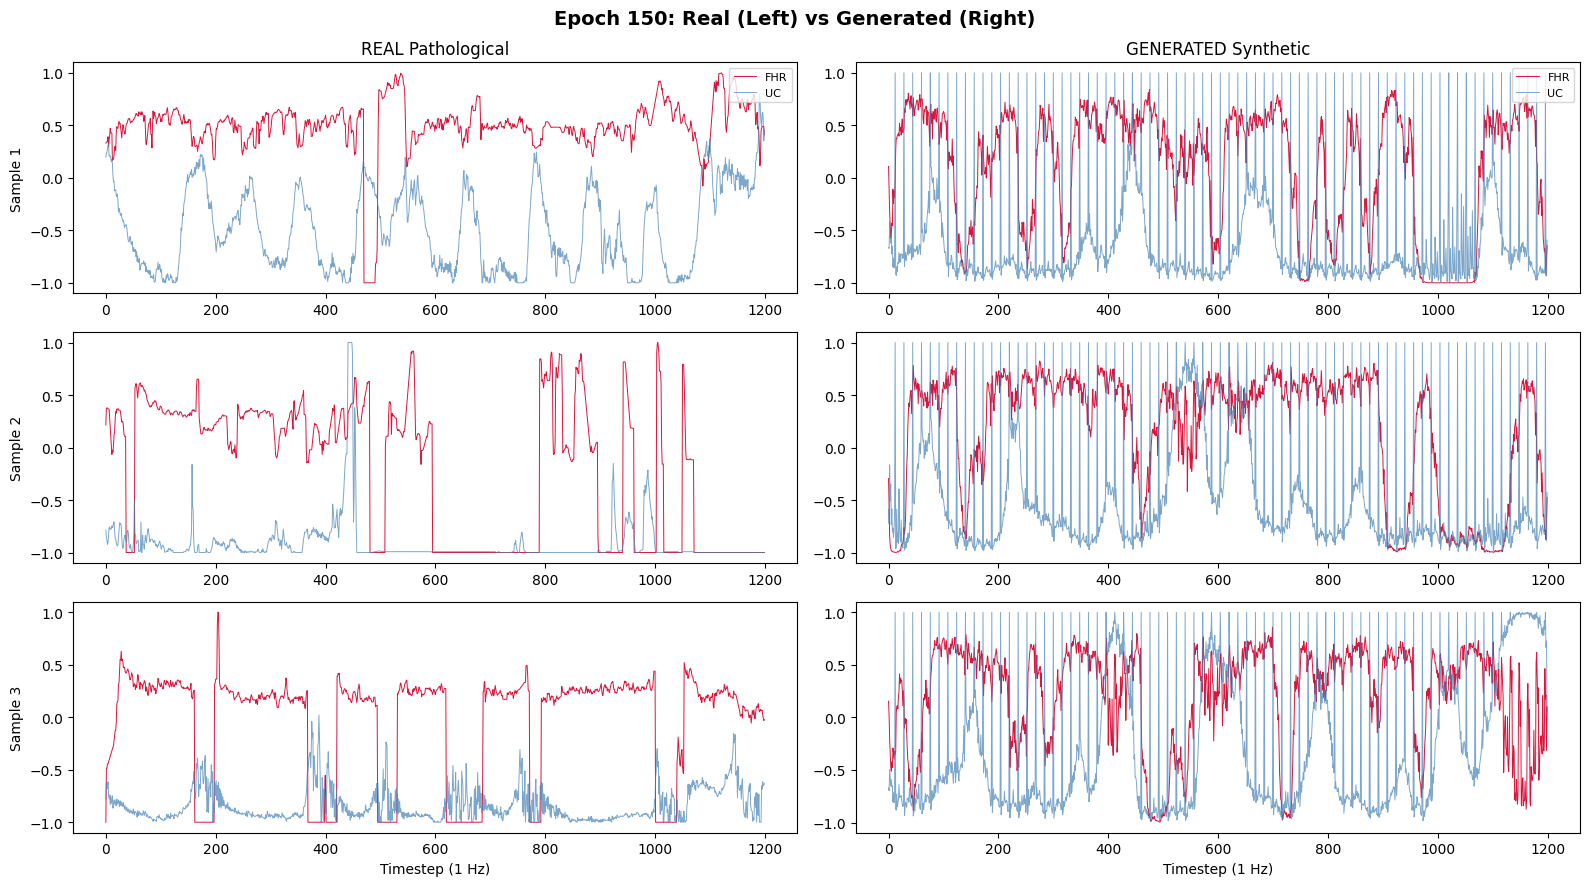

Epoch  160/500 | D Loss: -17.7624 | G Loss:  11.1393 | W Dist: -22.2160 | Time: 81s
Epoch  170/500 | D Loss: -17.6163 | G Loss:  11.2290 | W Dist: -22.0488 | Time: 86s
Epoch  180/500 | D Loss: -17.5038 | G Loss:  14.6549 | W Dist: -21.9233 | Time: 90s
Epoch  190/500 | D Loss: -17.4768 | G Loss:  13.1653 | W Dist: -21.8933 | Time: 94s
Epoch  200/500 | D Loss: -17.3302 | G Loss:  18.0066 | W Dist: -21.7453 | Time: 99s


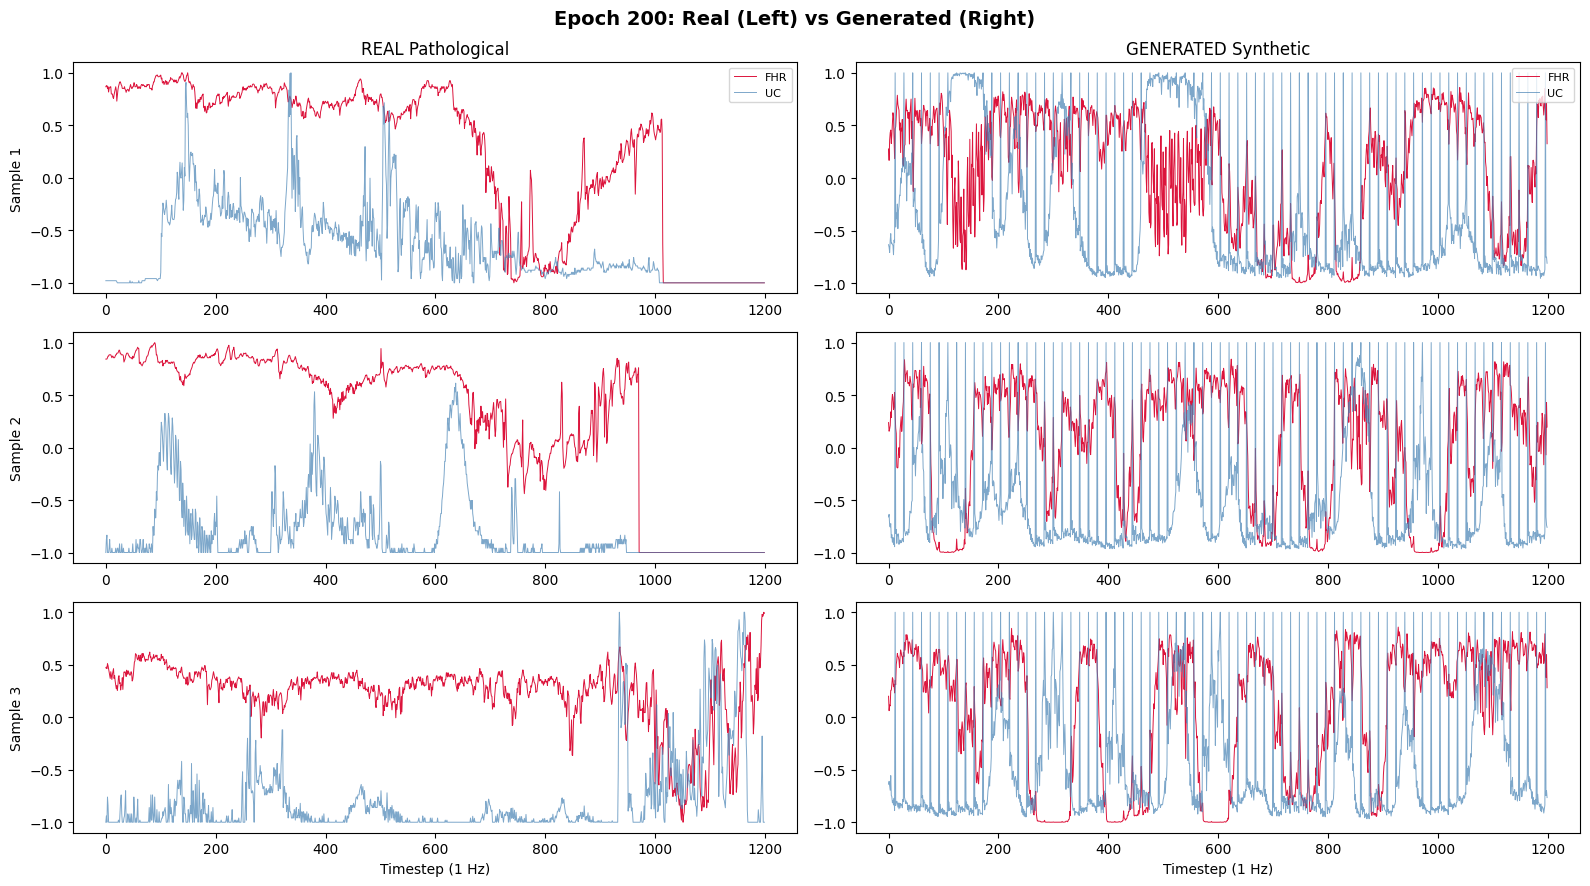

Epoch  210/500 | D Loss: -17.3901 | G Loss:  14.0953 | W Dist: -21.8130 | Time: 105s
Epoch  220/500 | D Loss: -17.7029 | G Loss:  16.0435 | W Dist: -22.1427 | Time: 109s
Epoch  230/500 | D Loss: -17.4770 | G Loss:  12.9628 | W Dist: -21.9300 | Time: 113s
Epoch  240/500 | D Loss: -17.8324 | G Loss:  16.2647 | W Dist: -22.2678 | Time: 117s
Epoch  250/500 | D Loss: -17.5049 | G Loss:  14.8778 | W Dist: -21.9685 | Time: 122s


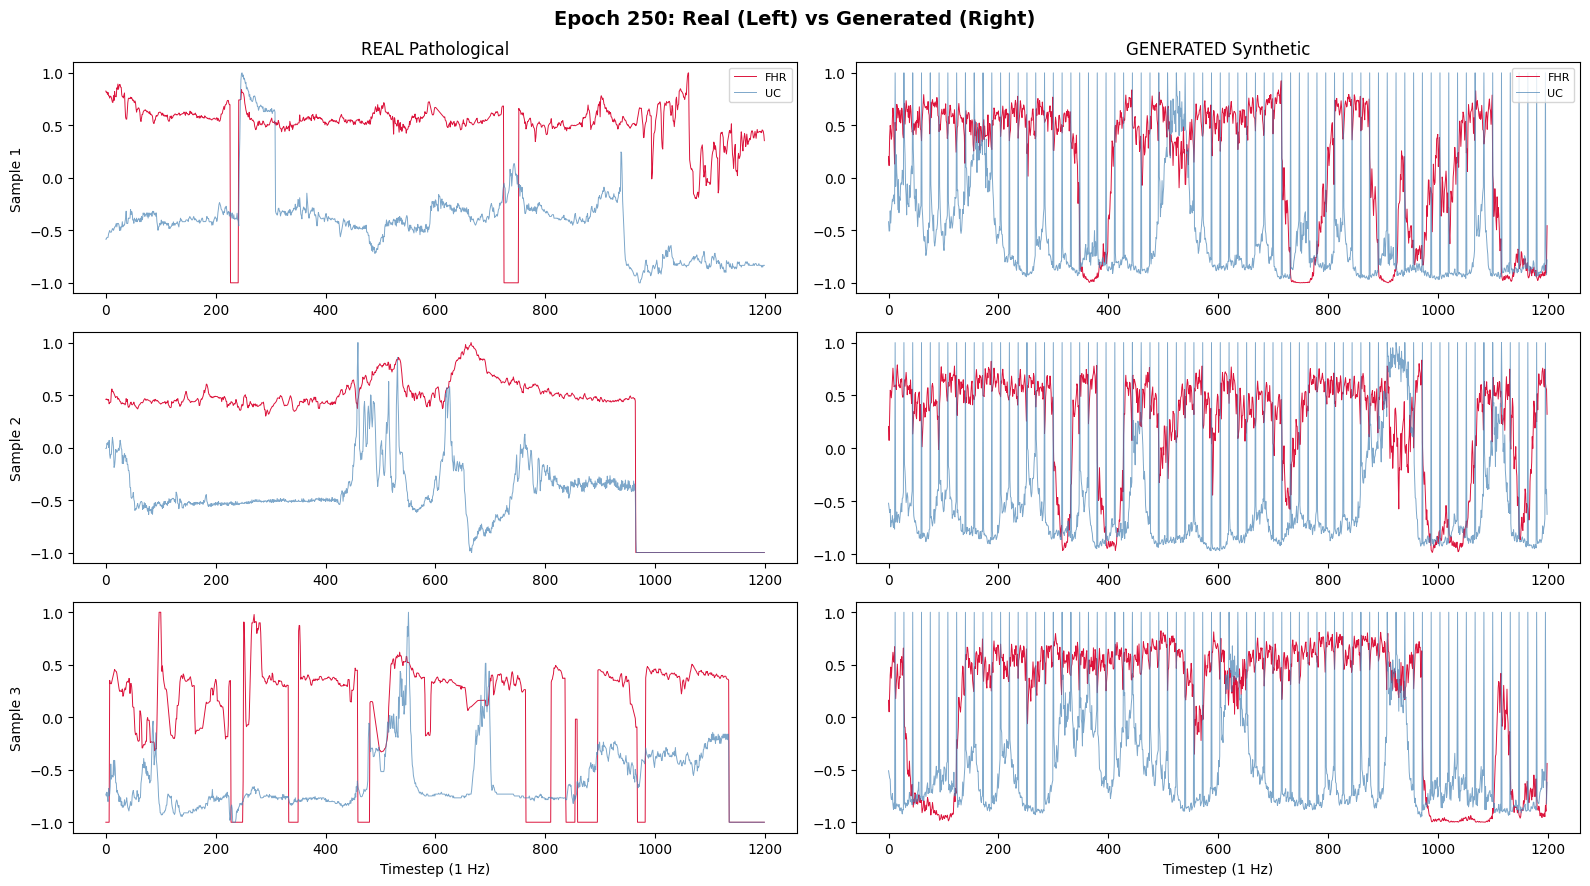

Epoch  260/500 | D Loss: -17.7894 | G Loss:  16.2143 | W Dist: -22.2583 | Time: 127s
Epoch  270/500 | D Loss:   1.3764 | G Loss: 101.9102 | W Dist:   1.0869 | Time: 132s
Epoch  280/500 | D Loss:   0.3808 | G Loss: 132.7229 | W Dist:   0.2941 | Time: 136s
Epoch  290/500 | D Loss:   0.4892 | G Loss: 143.9404 | W Dist:   0.4353 | Time: 140s
Epoch  300/500 | D Loss:   0.0021 | G Loss: 147.3192 | W Dist:  -0.0273 | Time: 145s


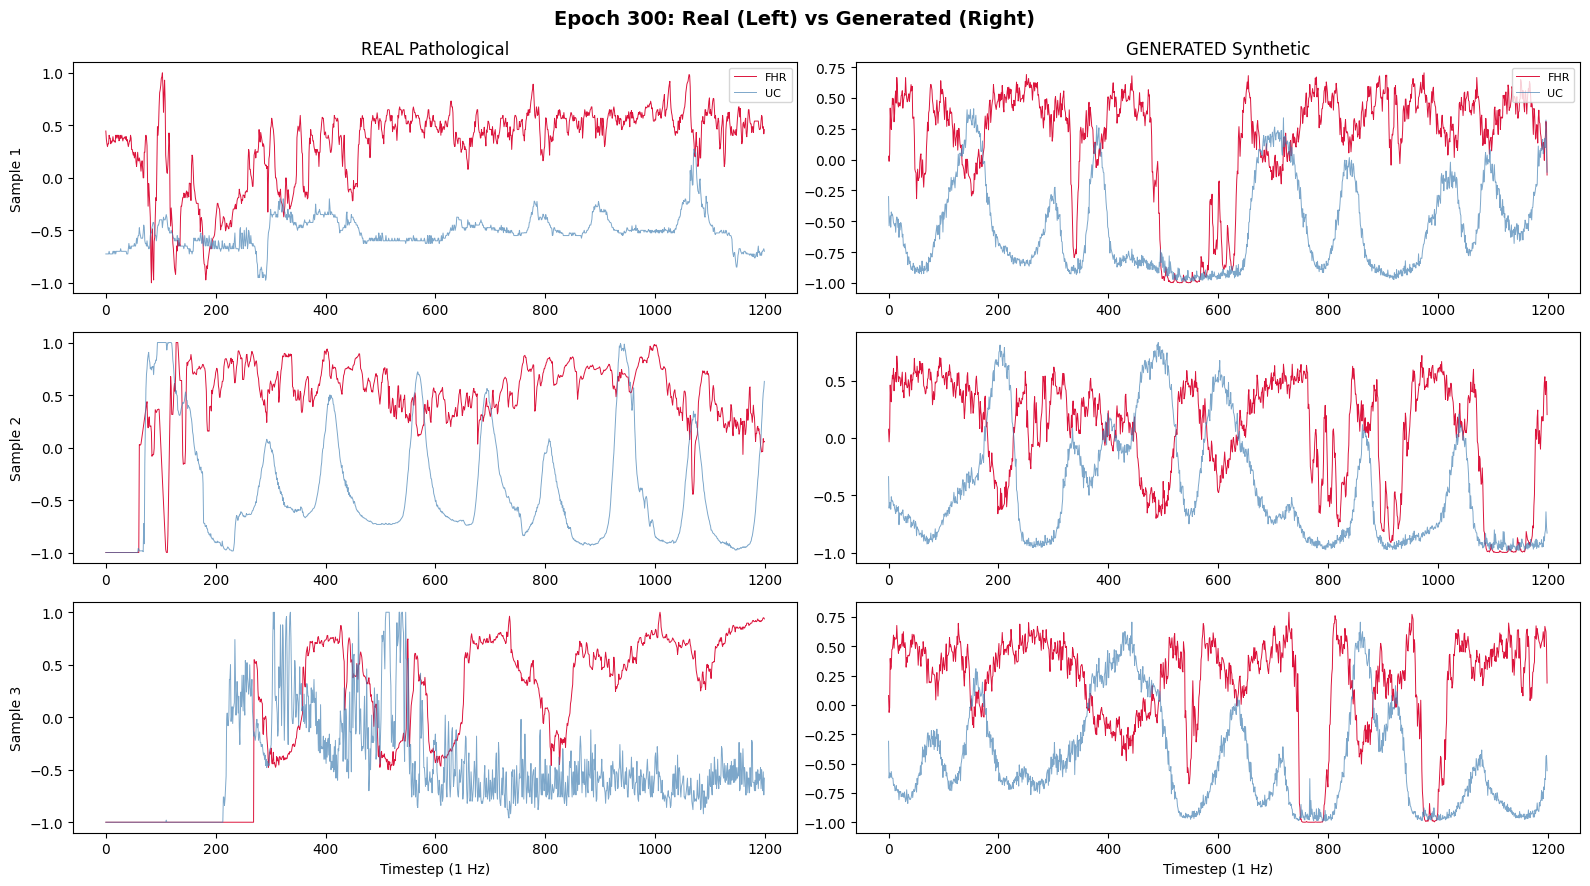

Epoch  310/500 | D Loss:  -0.0701 | G Loss: 152.9775 | W Dist:  -0.1022 | Time: 150s
Epoch  320/500 | D Loss:   0.2292 | G Loss: 117.1665 | W Dist:   0.1947 | Time: 155s
Epoch  330/500 | D Loss:   0.0342 | G Loss:  91.5831 | W Dist:   0.0131 | Time: 159s
Epoch  340/500 | D Loss:   0.4274 | G Loss:  82.8427 | W Dist:   0.3938 | Time: 164s
Epoch  350/500 | D Loss:   0.5041 | G Loss: 100.4240 | W Dist:   0.4844 | Time: 168s


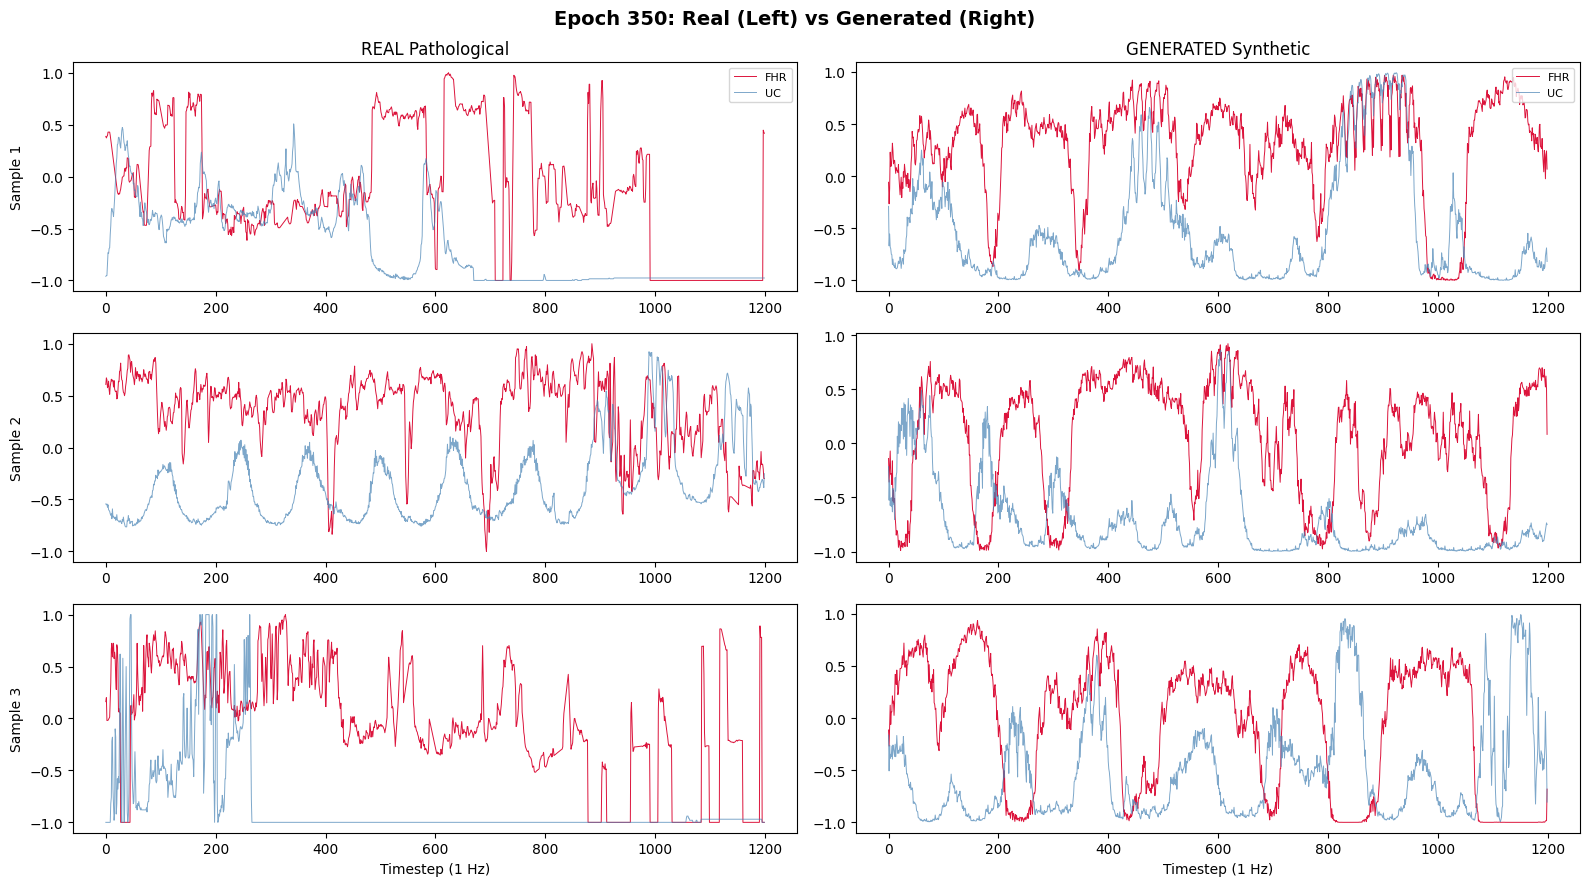

Epoch  360/500 | D Loss:   0.3096 | G Loss:  91.9750 | W Dist:   0.2941 | Time: 174s
Epoch  370/500 | D Loss:   0.4802 | G Loss:  90.9192 | W Dist:   0.4608 | Time: 178s
Epoch  380/500 | D Loss:   0.7974 | G Loss:  98.6099 | W Dist:   0.7781 | Time: 183s
Epoch  390/500 | D Loss:  -0.7316 | G Loss: 112.1355 | W Dist:  -0.7551 | Time: 187s
Epoch  400/500 | D Loss:  -0.2164 | G Loss:  95.7072 | W Dist:  -0.2402 | Time: 192s


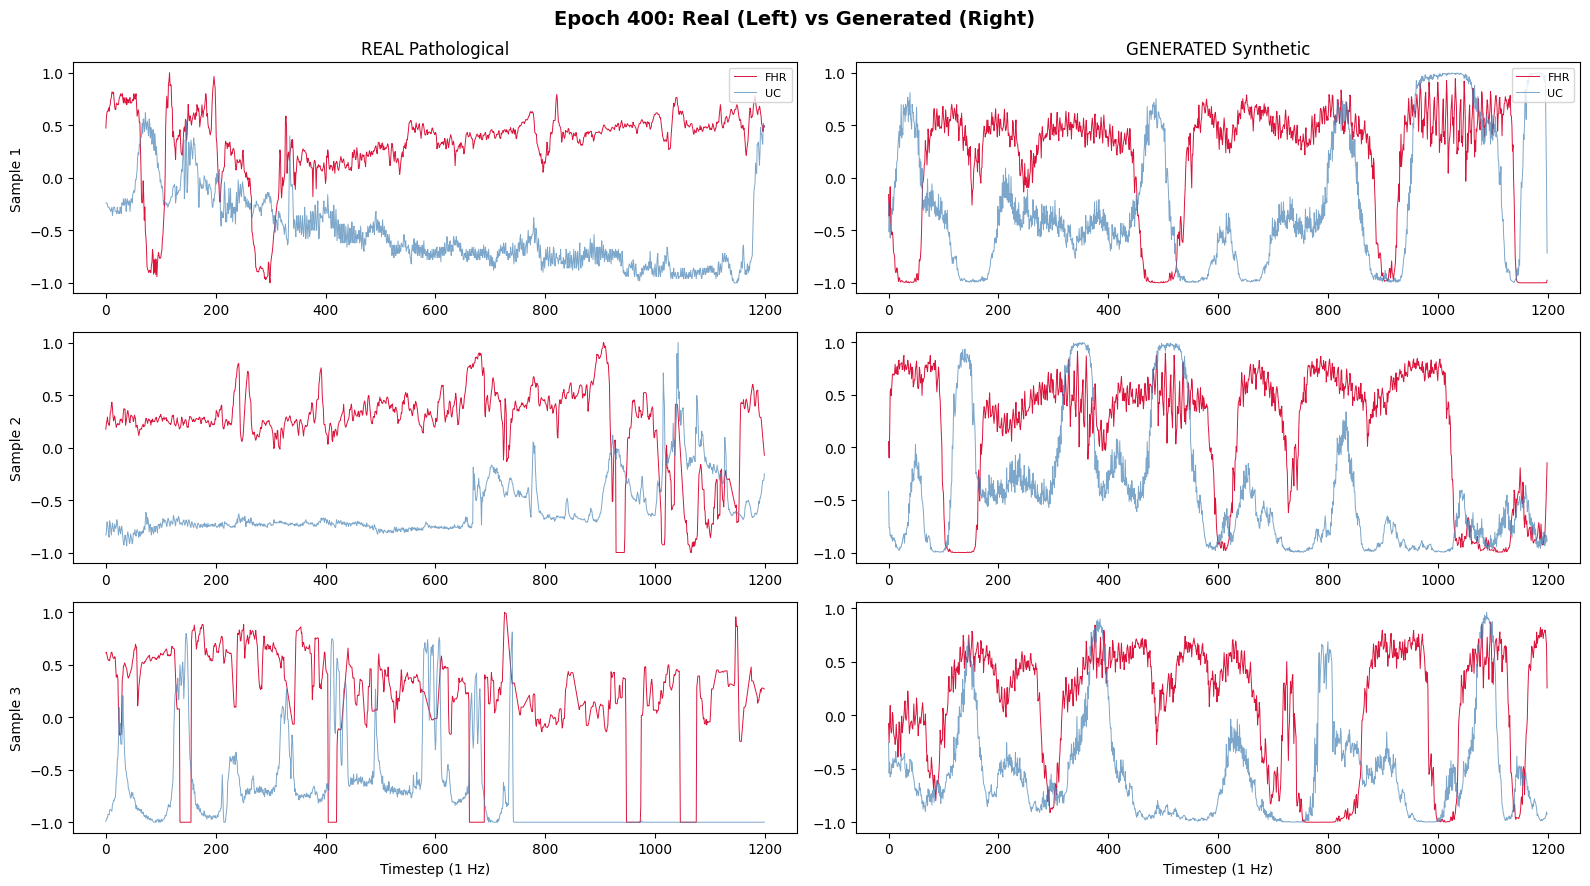

Epoch  410/500 | D Loss:  -0.2761 | G Loss: 101.8831 | W Dist:  -0.3009 | Time: 197s
Epoch  420/500 | D Loss:   0.2836 | G Loss: 113.7266 | W Dist:   0.2688 | Time: 201s
Epoch  430/500 | D Loss:   0.6983 | G Loss: 104.5649 | W Dist:   0.6744 | Time: 206s
Epoch  440/500 | D Loss:  -0.0203 | G Loss:  81.1899 | W Dist:  -0.0504 | Time: 210s
Epoch  450/500 | D Loss:   0.1245 | G Loss:  70.9066 | W Dist:   0.1035 | Time: 214s


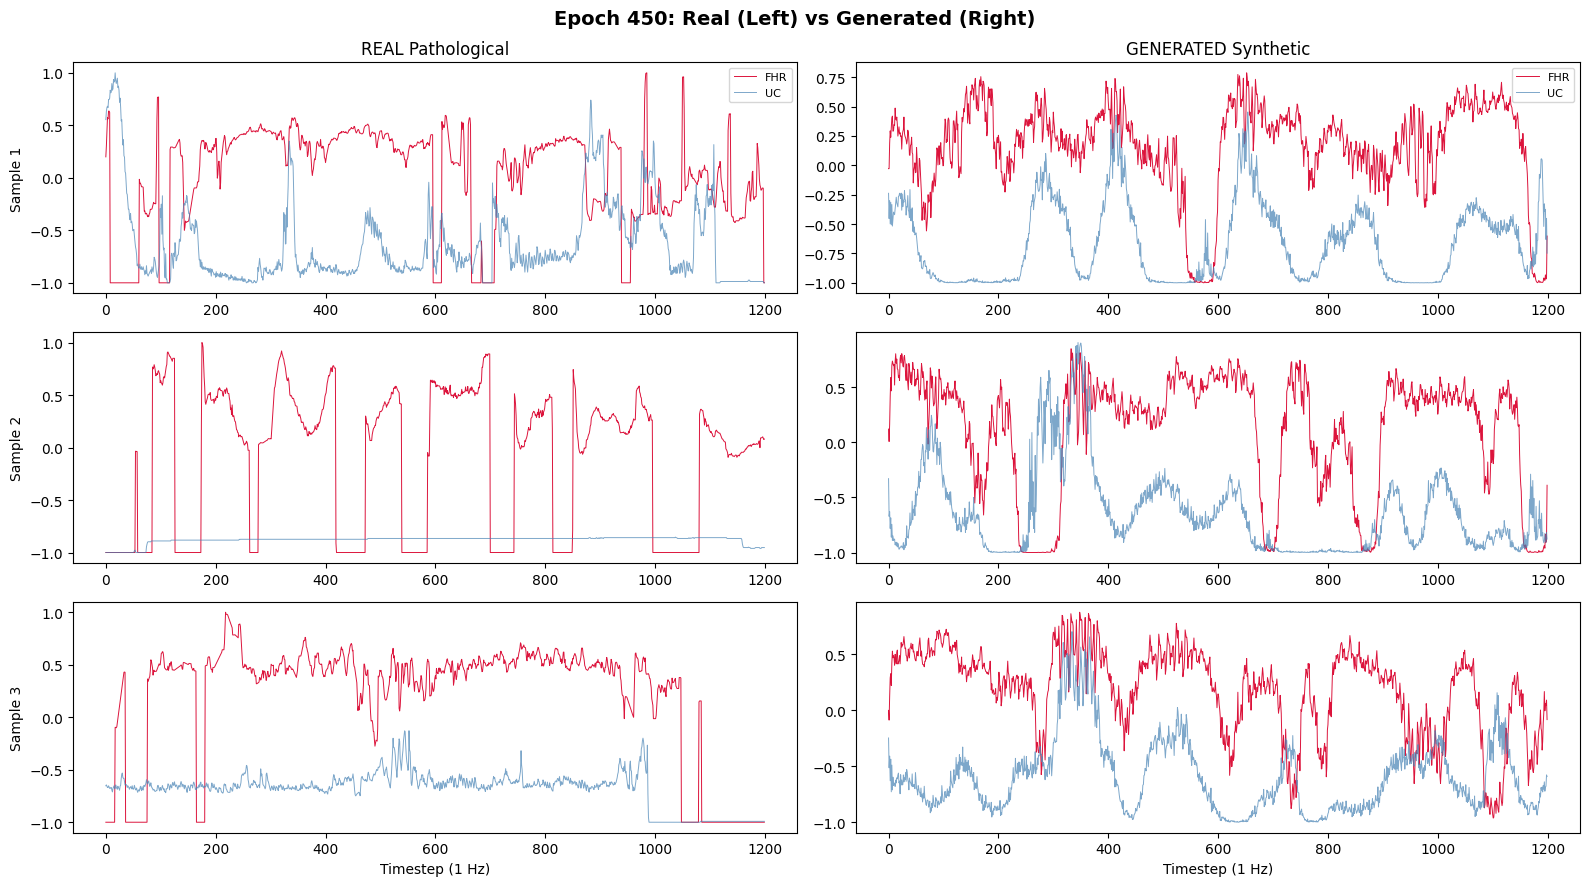

Epoch  460/500 | D Loss:   0.2926 | G Loss:  76.9926 | W Dist:   0.2770 | Time: 221s
Epoch  470/500 | D Loss:   0.0855 | G Loss:  74.3746 | W Dist:   0.0672 | Time: 225s
Epoch  480/500 | D Loss:  -0.2171 | G Loss:  69.2547 | W Dist:  -0.2435 | Time: 229s
Epoch  490/500 | D Loss:  -0.5601 | G Loss:  51.7547 | W Dist:  -0.5888 | Time: 234s
Epoch  500/500 | D Loss:  -0.3790 | G Loss:  64.0377 | W Dist:  -0.3930 | Time: 238s


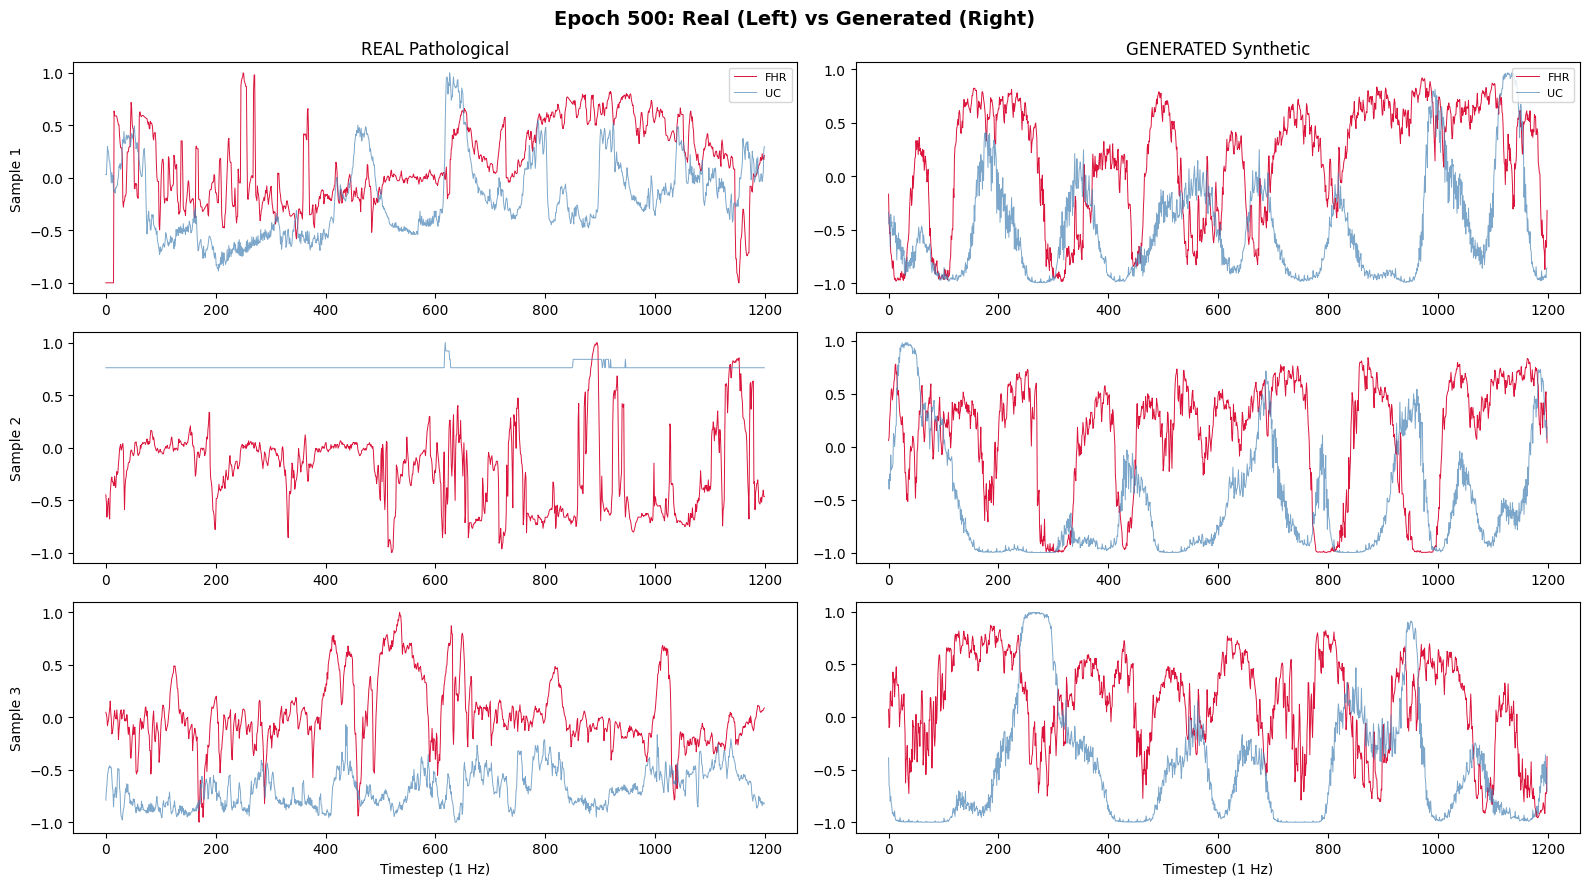


✓ Training complete in 4.0 minutes!


In [7]:
import time
from IPython.display import clear_output

# ── Optimizers ──
gen_optimizer    = keras.optimizers.Adam(LR_G, beta_1=0.0, beta_2=0.9)
critic_optimizer = keras.optimizers.Adam(LR_D, beta_1=0.0, beta_2=0.9)

# ── Prepare dataset ──
# Normalize data to [-1, 1] range for tanh generator output
data_min = X_patho_stacked.min(axis=(0, 1), keepdims=True)
data_max = X_patho_stacked.max(axis=(0, 1), keepdims=True)
data_range = data_max - data_min
data_range[data_range == 0] = 1.0  # Avoid division by zero

X_normalized = 2.0 * (X_patho_stacked - data_min) / data_range - 1.0
X_normalized = X_normalized.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(X_normalized)
dataset = dataset.shuffle(buffer_size=len(X_normalized)).batch(BATCH_SIZE, drop_remainder=True)

print(f"Training data: {X_normalized.shape} normalized to [-1, 1]")
print(f"Batches per epoch: {len(X_normalized) // BATCH_SIZE}")

# ═══════════════════════════════════════════════════════════════════
# Gradient Penalty
# ═══════════════════════════════════════════════════════════════════
@tf.function
def gradient_penalty(real_samples, fake_samples):
    """Computes gradient penalty for WGAN-GP."""
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = real_samples + alpha * (fake_samples - real_samples)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = gp_tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-8)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# ═══════════════════════════════════════════════════════════════════
# Single Training Step
# ═══════════════════════════════════════════════════════════════════
@tf.function
def train_critic_step(real_batch):
    """One critic update step."""
    noise = tf.random.normal((tf.shape(real_batch)[0], NOISE_DIM))

    with tf.GradientTape() as tape:
        fake_batch = generator(noise, training=True)
        real_score  = critic(real_batch, training=True)
        fake_score  = critic(fake_batch, training=True)

        # Wasserstein loss: maximize E[D(real)] - E[D(fake)]
        # Critic minimizes: E[D(fake)] - E[D(real)] + GP
        w_loss = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score)
        gp = gradient_penalty(real_batch, fake_batch)
        critic_loss = w_loss + GP_WEIGHT * gp

    grads = tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return critic_loss, w_loss

@tf.function
def train_generator_step():
    """One generator update step."""
    noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))

    with tf.GradientTape() as tape:
        fake_batch = generator(noise, training=True)
        fake_score = critic(fake_batch, training=True)
        # Generator wants critic to score fakes highly
        gen_loss = -tf.reduce_mean(fake_score)

    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return gen_loss

# ═══════════════════════════════════════════════════════════════════
# Visualization Helper
# ═══════════════════════════════════════════════════════════════════
def visualize_comparison(epoch, real_data, n_samples=3):
    """Plot real vs generated traces side by side."""
    noise = tf.random.normal((n_samples, NOISE_DIM))
    generated = generator(noise, training=False).numpy()

    fig, axes = plt.subplots(n_samples, 2, figsize=(16, 3 * n_samples))
    fig.suptitle(f'Epoch {epoch}: Real (Left) vs Generated (Right)', fontsize=14, fontweight='bold')

    for i in range(n_samples):
        # Pick a random real sample
        real_idx = np.random.randint(0, len(real_data))

        # Real trace
        axes[i, 0].plot(real_data[real_idx, :, 0], color='crimson', linewidth=0.7, label='FHR')
        axes[i, 0].plot(real_data[real_idx, :, 1], color='steelblue', linewidth=0.7, alpha=0.7, label='UC')
        axes[i, 0].set_ylabel(f'Sample {i+1}')
        if i == 0:
            axes[i, 0].set_title('REAL Pathological')
            axes[i, 0].legend(loc='upper right', fontsize=8)

        # Generated trace
        axes[i, 1].plot(generated[i, :, 0], color='crimson', linewidth=0.7, label='FHR')
        axes[i, 1].plot(generated[i, :, 1], color='steelblue', linewidth=0.7, alpha=0.7, label='UC')
        if i == 0:
            axes[i, 1].set_title('GENERATED Synthetic')
            axes[i, 1].legend(loc='upper right', fontsize=8)

    axes[-1, 0].set_xlabel('Timestep (1 Hz)')
    axes[-1, 1].set_xlabel('Timestep (1 Hz)')
    plt.tight_layout()
    os.makedirs('Code/models', exist_ok=True)
    plt.savefig(f'Code/models/gan_comparison_epoch_{epoch}.png', dpi=100, bbox_inches='tight')
    plt.show()

# ═══════════════════════════════════════════════════════════════════
# Main Training Loop
# ═══════════════════════════════════════════════════════════════════
os.makedirs('Code/models', exist_ok=True)

print(f"\n{'='*60}")
print(f"Starting WGAN-GP Training — {EPOCHS} epochs")
print(f"Generator LR: {LR_G}, Critic LR: {LR_D}")
print(f"Critic updates per G update: {N_CRITIC}")
print(f"Batch size: {BATCH_SIZE}")
print(f"{'='*60}\n")

history = {'d_loss': [], 'g_loss': [], 'w_dist': []}
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_d_loss = []
    epoch_g_loss = []
    epoch_w_dist = []

    for step, real_batch in enumerate(dataset):
        # ── Train Critic N_CRITIC times ──
        d_loss, w_dist = train_critic_step(real_batch)
        epoch_d_loss.append(float(d_loss))
        epoch_w_dist.append(float(w_dist))

        # ── Train Generator once every N_CRITIC steps ──
        if step % N_CRITIC == 0:
            g_loss = train_generator_step()
            epoch_g_loss.append(float(g_loss))

    # Record epoch averages
    avg_d = np.mean(epoch_d_loss)
    avg_g = np.mean(epoch_g_loss) if epoch_g_loss else 0
    avg_w = np.mean(epoch_w_dist)
    history['d_loss'].append(avg_d)
    history['g_loss'].append(avg_g)
    history['w_dist'].append(avg_w)

    # Print progress
    if epoch % 10 == 0 or epoch == 1:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch:>4d}/{EPOCHS} | D Loss: {avg_d:>8.4f} | G Loss: {avg_g:>8.4f} | W Dist: {avg_w:>8.4f} | Time: {elapsed:.0f}s")

    # Visualize every 50 epochs
    if epoch % 50 == 0:
        visualize_comparison(epoch, X_normalized, n_samples=3)

total_time = time.time() - start_time
print(f"\n✓ Training complete in {total_time/60:.1f} minutes!")

---
## 5. Training Diagnostics

Plot the loss curves to verify stable convergence. For WGAN-GP:
- The **Wasserstein distance** (W Dist) should decrease over time, indicating the generator is fooling the critic.
- Loss curves should **not** diverge wildly.

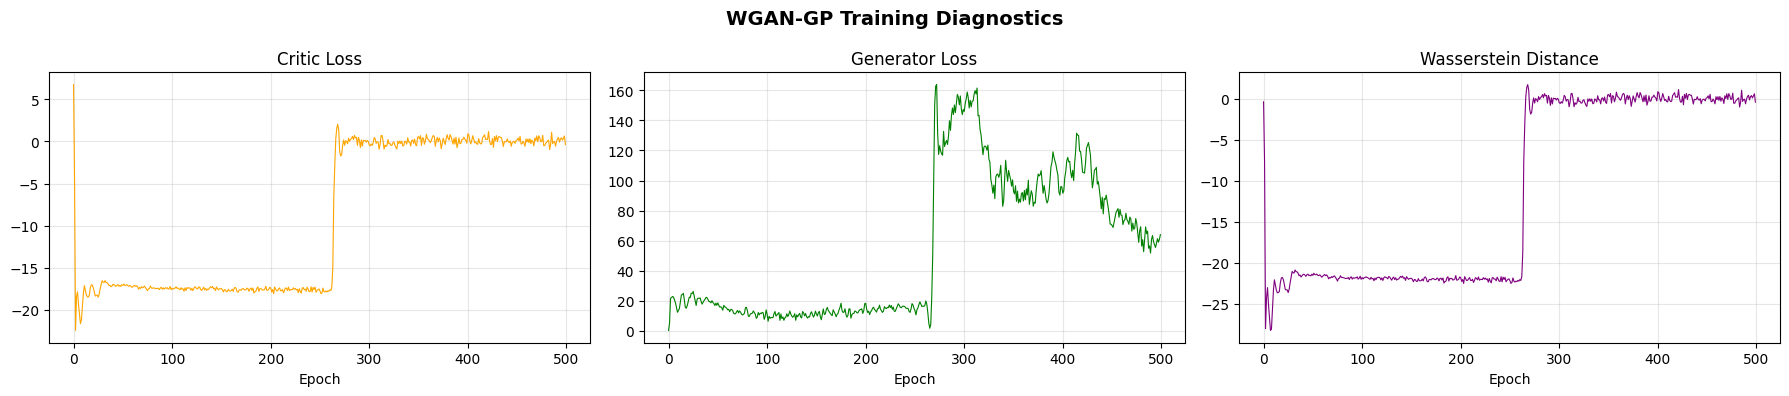

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(history['d_loss'], color='orange', linewidth=0.8)
axes[0].set_title('Critic Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

axes[1].plot(history['g_loss'], color='green', linewidth=0.8)
axes[1].set_title('Generator Loss')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

axes[2].plot(history['w_dist'], color='purple', linewidth=0.8)
axes[2].set_title('Wasserstein Distance')
axes[2].set_xlabel('Epoch')
axes[2].grid(alpha=0.3)

plt.suptitle('WGAN-GP Training Diagnostics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Code/models/gan_training_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Generate & Export Synthetic Data

Generate **3x** the original pathological count as new synthetic samples. These will be used to replace SMOTE in the V4.0 training pipeline.

We also perform a statistical sanity check: compare mean/std of real vs synthetic per channel.

In [9]:
# ── Configuration ──
N_SYNTHETIC = len(X_fhr_patho) * 3  # 3x oversampling
print(f"Generating {N_SYNTHETIC} synthetic pathological traces...")

# ── Batch generation to avoid OOM ──
synthetic_batches = []
gen_batch_size = 64
for i in range(0, N_SYNTHETIC, gen_batch_size):
    batch_n = min(gen_batch_size, N_SYNTHETIC - i)
    noise = tf.random.normal((batch_n, NOISE_DIM))
    synthetic_batch = generator(noise, training=False).numpy()
    synthetic_batches.append(synthetic_batch)

X_synthetic_normalized = np.concatenate(synthetic_batches, axis=0)  # (N_SYNTHETIC, 1200, 2)

# ── De-normalize back to original scale ──
X_synthetic = (X_synthetic_normalized + 1.0) / 2.0 * data_range + data_min

# ── Split back into FHR and UC ──
X_fhr_synthetic = X_synthetic[:, :, 0:1]  # (N, 1200, 1)
X_uc_synthetic  = X_synthetic[:, :, 1:2]   # (N, 1200, 1)

print(f"\nSynthetic FHR shape: {X_fhr_synthetic.shape}")
print(f"Synthetic UC  shape: {X_uc_synthetic.shape}")

# ── Statistical Validation ──
print(f"\n{'='*50}")
print(f"Statistical Comparison: Real vs Synthetic")
print(f"{'='*50}")
for ch, name in enumerate(['FHR', 'UC']):
    real_mean = X_patho_stacked[:, :, ch].mean()
    real_std  = X_patho_stacked[:, :, ch].std()
    syn_mean  = X_synthetic[:, :, ch].mean()
    syn_std   = X_synthetic[:, :, ch].std()
    print(f"  {name} — Real: mean={real_mean:.4f} std={real_std:.4f} | Synth: mean={syn_mean:.4f} std={syn_std:.4f}")

# ── Save synthetic arrays ──
os.makedirs("Datasets/synthetic", exist_ok=True)
np.save("Datasets/synthetic/X_fhr_synthetic.npy", X_fhr_synthetic)
np.save("Datasets/synthetic/X_uc_synthetic.npy", X_uc_synthetic)

# ── Save generator weights ──
generator.save("Code/models/generator_v4.keras")

# ── Save normalization params for reproducibility ──
np.save("Datasets/synthetic/data_min.npy", data_min)
np.save("Datasets/synthetic/data_max.npy", data_max)

print(f"\n✓ Saved synthetic data to Datasets/synthetic/")
print(f"✓ Saved generator weights to Code/models/generator_v4.keras")

Generating 1410 synthetic pathological traces...

Synthetic FHR shape: (1410, 1200, 1)
Synthetic UC  shape: (1410, 1200, 1)

Statistical Comparison: Real vs Synthetic
  FHR — Real: mean=0.5570 std=0.2647 | Synth: mean=0.5734 std=0.2591
  UC — Real: mean=0.2221 std=0.2265 | Synth: mean=0.2206 std=0.2261

✓ Saved synthetic data to Datasets/synthetic/
✓ Saved generator weights to Code/models/generator_v4.keras


---
## 7. Final Visual Comparison (Publication Quality)

Generate a clean figure comparing 5 real and 5 synthetic traces — suitable for your mid-semester presentation or paper.

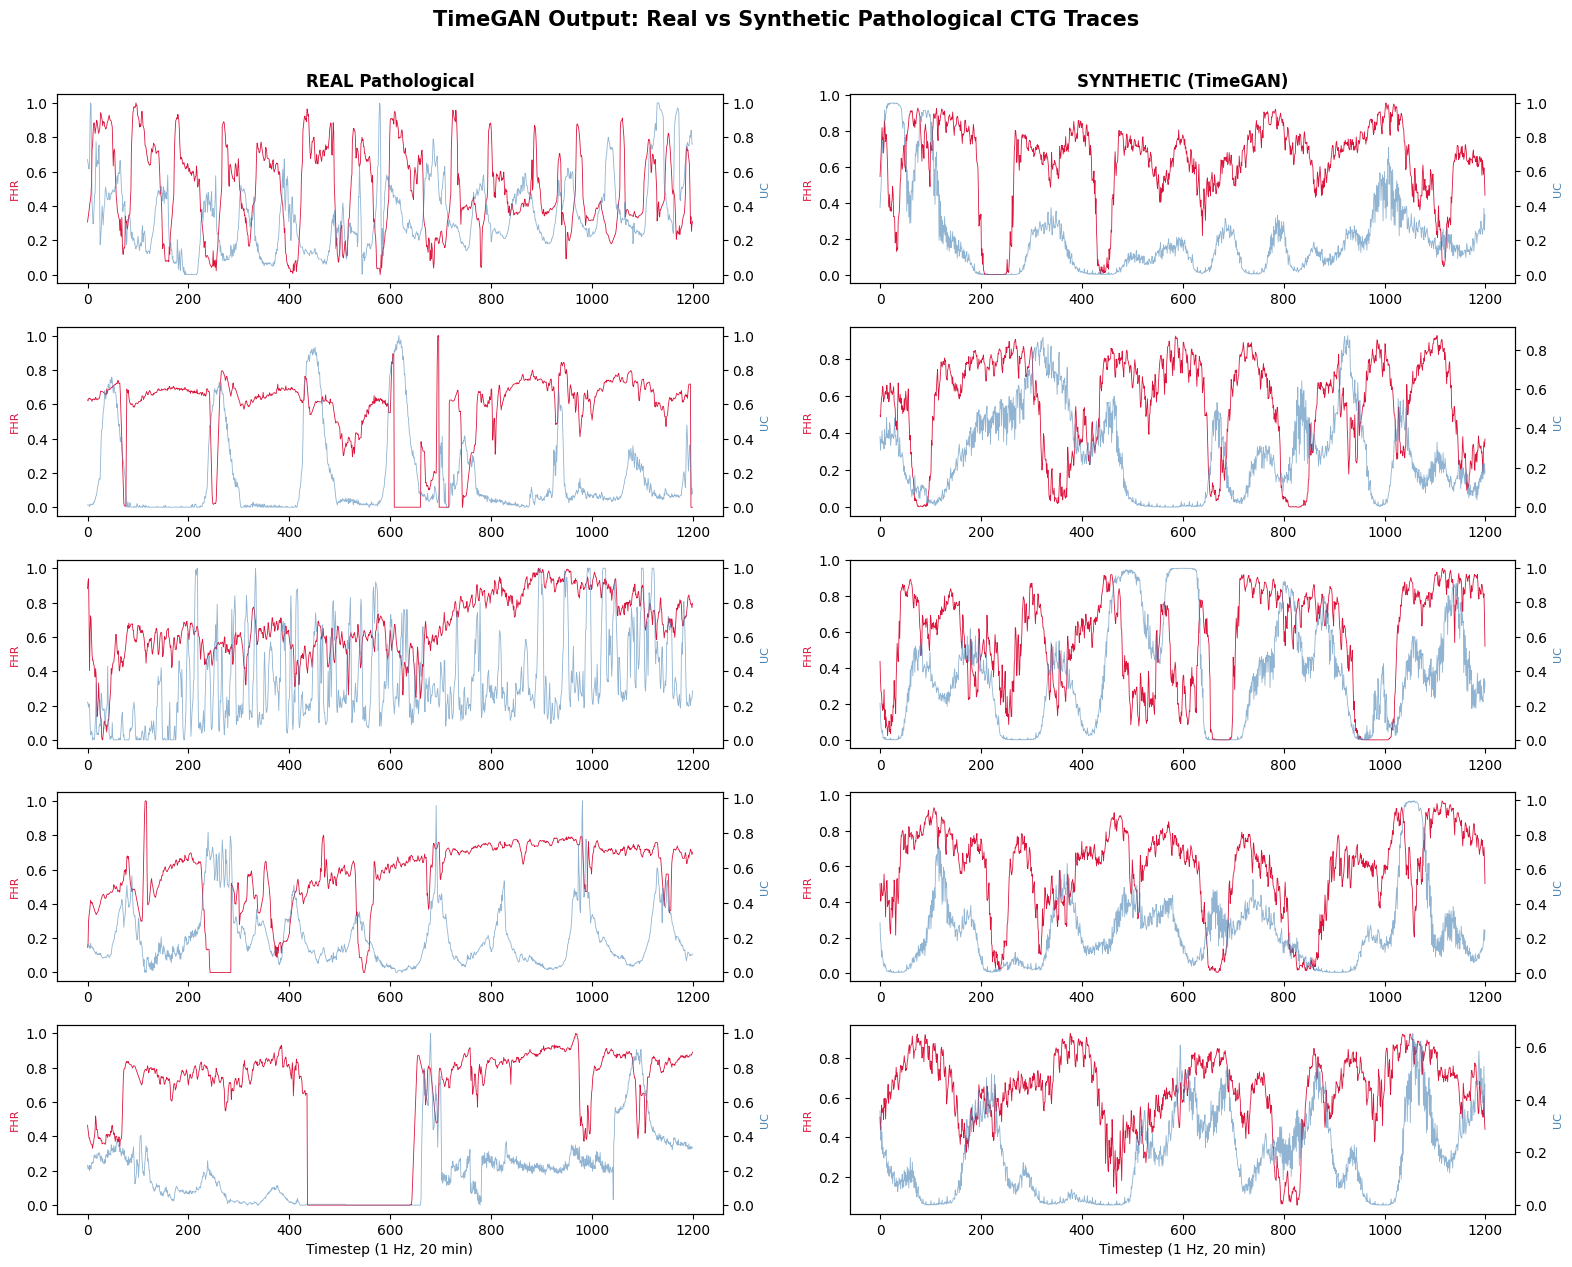

✓ Publication-quality comparison saved to Code/models/timegan_final_comparison.png


In [10]:
n_show = 5
fig, axes = plt.subplots(n_show, 2, figsize=(16, 2.5 * n_show))
fig.suptitle('TimeGAN Output: Real vs Synthetic Pathological CTG Traces',
             fontsize=15, fontweight='bold', y=1.01)

for i in range(n_show):
    real_idx = np.random.randint(0, len(X_fhr_patho))
    syn_idx  = np.random.randint(0, len(X_fhr_synthetic))

    # Real (squeeze to 1D for plotting)
    axes[i, 0].plot(X_fhr_patho[real_idx].squeeze(), color='crimson', linewidth=0.6, label='FHR')
    ax2 = axes[i, 0].twinx()
    ax2.plot(X_uc_patho[real_idx].squeeze(), color='steelblue', linewidth=0.6, alpha=0.6, label='UC')
    ax2.set_ylabel('UC', color='steelblue', fontsize=8)
    axes[i, 0].set_ylabel('FHR', color='crimson', fontsize=8)

    # Synthetic (squeeze to 1D for plotting)
    axes[i, 1].plot(X_fhr_synthetic[syn_idx].squeeze(), color='crimson', linewidth=0.6, label='FHR')
    ax2s = axes[i, 1].twinx()
    ax2s.plot(X_uc_synthetic[syn_idx].squeeze(), color='steelblue', linewidth=0.6, alpha=0.6, label='UC')
    ax2s.set_ylabel('UC', color='steelblue', fontsize=8)
    axes[i, 1].set_ylabel('FHR', color='crimson', fontsize=8)

axes[0, 0].set_title('REAL Pathological', fontsize=12, fontweight='bold')
axes[0, 1].set_title('SYNTHETIC (TimeGAN)', fontsize=12, fontweight='bold')
axes[-1, 0].set_xlabel('Timestep (1 Hz, 20 min)')
axes[-1, 1].set_xlabel('Timestep (1 Hz, 20 min)')

plt.tight_layout()
plt.savefig('Code/models/timegan_final_comparison.png', dpi=200, bbox_inches='tight')
plt.show()
print("✓ Publication-quality comparison saved to Code/models/timegan_final_comparison.png")

---
## 8. Integration Stub: V4.0 Ensemble Training

The following code shows exactly how to inject the synthetic data into the existing training pipeline. This replaces SMOTE in the K-Fold loop inside `train_diverse_ensemble.py`.

In [11]:
# ═══════════════════════════════════════════════════════════════════
# Integration Example: Replace SMOTE with TimeGAN Synthetic Data
# Paste this logic into the K-Fold loop of train_diverse_ensemble.py
# ═══════════════════════════════════════════════════════════════════

def load_and_augment_with_timegan(X_fhr_train, X_uc_train, X_tab_train, y_train):
    """
    Replaces SMOTE by injecting TimeGAN-generated synthetic pathological
    traces into the training fold.

    Returns augmented arrays with balanced classes.
    """
    # Load synthetic data
    X_fhr_syn = np.load("Datasets/synthetic/X_fhr_synthetic.npy")
    X_uc_syn  = np.load("Datasets/synthetic/X_uc_synthetic.npy")

    # Squeeze to 2D if training pipeline expects (N, 1200)
    if X_fhr_train.ndim == 2 and X_fhr_syn.ndim == 3:
        X_fhr_syn = X_fhr_syn.squeeze(axis=-1)
        X_uc_syn  = X_uc_syn.squeeze(axis=-1)

    # Calculate how many synthetic samples we need to balance
    n_positive = int(y_train.sum())
    n_negative = len(y_train) - n_positive
    n_needed   = n_negative - n_positive  # Number to add to balance

    # Sample from synthetic pool (with replacement if needed)
    syn_indices = np.random.choice(len(X_fhr_syn), size=min(n_needed, len(X_fhr_syn)), replace=False)

    # Create synthetic tabular features by sampling from existing pathological
    patho_tab_idx = np.where(y_train == 1)[0]
    syn_tab_indices = np.random.choice(patho_tab_idx, size=len(syn_indices), replace=True)
    X_tab_syn = X_tab_train[syn_tab_indices]

    # Concatenate
    X_fhr_aug = np.concatenate([X_fhr_train, X_fhr_syn[syn_indices]], axis=0)
    X_uc_aug  = np.concatenate([X_uc_train, X_uc_syn[syn_indices]], axis=0)
    X_tab_aug = np.concatenate([X_tab_train, X_tab_syn], axis=0)
    y_aug     = np.concatenate([y_train, np.ones(len(syn_indices))], axis=0)

    # Shuffle
    perm = np.random.permutation(len(y_aug))
    X_fhr_aug = X_fhr_aug[perm]
    X_uc_aug  = X_uc_aug[perm]
    X_tab_aug = X_tab_aug[perm]
    y_aug     = y_aug[perm]

    print(f"  TimeGAN Aug: {n_positive} → {int(y_aug.sum())} positives / {len(y_aug)} total ({y_aug.mean()*100:.1f}%)")
    return X_fhr_aug, X_uc_aug, X_tab_aug, y_aug

print("✓ Integration function defined. Ready for V4.0 ensemble training.")
print("  Usage: Replace the SMOTE block in train.py/train_diverse_ensemble.py")
print("  with a call to load_and_augment_with_timegan().")

✓ Integration function defined. Ready for V4.0 ensemble training.
  Usage: Replace the SMOTE block in train.py/train_diverse_ensemble.py
  with a call to load_and_augment_with_timegan().


---
## 9. Push Results to GitHub

In [12]:
!git add Datasets/synthetic/ Code/models/generator_v4.keras Code/models/gan_*.png Code/models/timegan_*.png
!git commit -m "feat(v4.0): TimeGAN synthetic CTG generation — {N_SYNTHETIC} pathological traces"
!git push origin feat/v4.0-timegan
print("\n✓ All results pushed to feat/v4.0-timegan branch!")

[feat/v4.0-timegan 1105382] feat(v4.0): TimeGAN synthetic CTG generation — 1410 pathological traces
 17 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Code/models/gan_comparison_epoch_100.png
 create mode 100644 Code/models/gan_comparison_epoch_150.png
 create mode 100644 Code/models/gan_comparison_epoch_200.png
 create mode 100644 Code/models/gan_comparison_epoch_250.png
 create mode 100644 Code/models/gan_comparison_epoch_300.png
 create mode 100644 Code/models/gan_comparison_epoch_350.png
 create mode 100644 Code/models/gan_comparison_epoch_400.png
 create mode 100644 Code/models/gan_comparison_epoch_450.png
 create mode 100644 Code/models/gan_comparison_epoch_50.png
 create mode 100644 Code/models/gan_comparison_epoch_500.png
 create mode 100644 Code/models/gan_training_diagnostics.png
 create mode 100644 Code/models/generator_v4.keras
 create mode 100644 Code/models/timegan_final_comparison.png
 create mode 100644 Datasets/synthetic/X_fhr_synthetic.npy
 create 